In [1]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dense, Dropout,
    BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [ ]:
print("Dang ket noi voi google drive...")
drive.mount('/content/drive', force_remount=True)


drive_dataset_path = '/content/drive/MyDrive/dataset'   
local_dataset_path = '/content/dataset'               


print("\nBat dau sao chep du lieu tu Drive sang Colab...")
!rsync -a --info=progress2 "{drive_dataset_path}/" "{local_dataset_path}/"
print("Da sao chep du lieu thanh cong!")


Dang ket noi voi google drive...
Mounted at /content/drive

Bat dau sao chep du lieu tu Drive sang Colab...
     30,667,161 100%   12.41kB/s    0:40:12 (xfr#8000, to-chk=0/8011)
Da sao chep du lieu thanh cong!



CONFIG


In [4]:
IMG_WIDTH, IMG_HEIGHT = 100, 100
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)  # ẢNH MÀU RGB

BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = 4

print("\nBat dau chuan bi du lieu tu bo nho cuc bo...")


Bat dau chuan bi du lieu tu bo nho cuc bo...


AUGMENTATION

Found 6400 images belonging to 4 classes.
Found 1600 images belonging to 4 classes.
Cac cu chi duoc tim thay: ['0', '1', '2', '3']
Train samples: 6400
Val samples  : 1600
Batch x range: 0.05244142 1.0 shape: (32, 100, 100, 3)


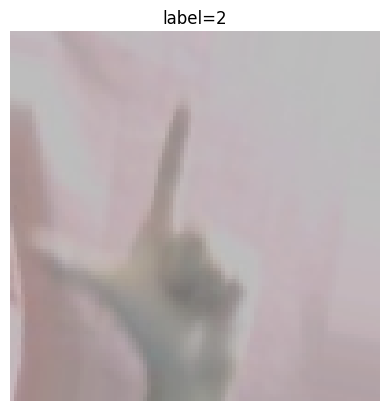

In [ ]:
def add_noise_contrast_and_rescale(img):
   
    img = img.astype(np.float32) / 255.0  

    
    if np.random.rand() < 0.7:
        factor = np.random.uniform(0.85, 1.15)
        mean = img.mean(axis=(0, 1), keepdims=True)
        img = (img - mean) * factor + mean

   
    if np.random.rand() < 0.7:
        noise = np.random.normal(0.0, 0.03, img.shape).astype(np.float32)
        img = img + noise

    return np.clip(img, 0.0, 1.0)

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.10,
    brightness_range=(0.8, 1.2),
    preprocessing_function=add_noise_contrast_and_rescale
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: x.astype(np.float32) / 255.0
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

CLASS_NAMES = sorted(train_generator.class_indices.keys())
print(f"Cac cu chi duoc tim thay: {CLASS_NAMES}")
print("Train samples:", train_generator.samples)
print("Val samples  :", validation_generator.samples)


x, y = next(train_generator)
print("Batch x range:", x.min(), x.max(), "shape:", x.shape)
plt.imshow(x[0])
plt.title(f"label={np.argmax(y[0])}")
plt.axis("off")
plt.show()

MODEL

In [6]:
print("\nBat dau xay dung mo hinh CNN...")

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_SHAPE),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    GlobalAveragePooling2D(),

    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.4),

    Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

print("\nBat dau bien dich va huan luyen...")

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

steps_per_epoch = math.ceil(train_generator.samples / BATCH_SIZE)
validation_steps = math.ceil(validation_generator.samples / BATCH_SIZE)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr]
)

print("Huan luyen hoan tat!")


Bat dau xay dung mo hinh CNN...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,172 (434.27 KB)

 Trainable params: 110,724 (432.52 KB)

 Non-trainable params: 448 (1.75 KB)


Bat dau bien dich va huan luyen...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 158ms/step - accuracy: 0.3906 - loss: 1.3685 - val_accuracy: 0.2506 - val_loss: 1.4167 - learning_rate: 0.0010
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 35s 152ms/step - accuracy: 0.6969 - loss: 0.8425 - val_accuracy: 0.3113 - val_loss: 1.5210 - learning_rate: 0.0010
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 155ms/step - accuracy: 0.8133 - loss: 0.6095 - val_accuracy: 0.4994 - val_loss: 1.3599 - learning_rate: 0.0010
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 150ms/step - accuracy: 0.9291 - loss: 0.4428 - val_accuracy: 0.5838 - val_loss: 1.3259 - learning_rate: 0.0010
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 152ms/step - accuracy: 0.9704 - loss: 0.3426 - val_accuracy: 0.8056 - val_loss: 0.6896 - learning_rate: 0.0010
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 153ms/step - accuracy: 0.9858 - loss: 0.2985 - val_accuracy: 0.8700 - val_loss: 0.6251 - learning_rate: 0.0010
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 150ms/step - accuracy: 0.9

In [7]:
print("Train class_indices:", train_generator.class_indices)
print("Val class_indices  :", validation_generator.class_indices)


Train class_indices: {'0': 0, '1': 1, '2': 2, '3': 3}
Val class_indices  : {'0': 0, '1': 1, '2': 2, '3': 3}


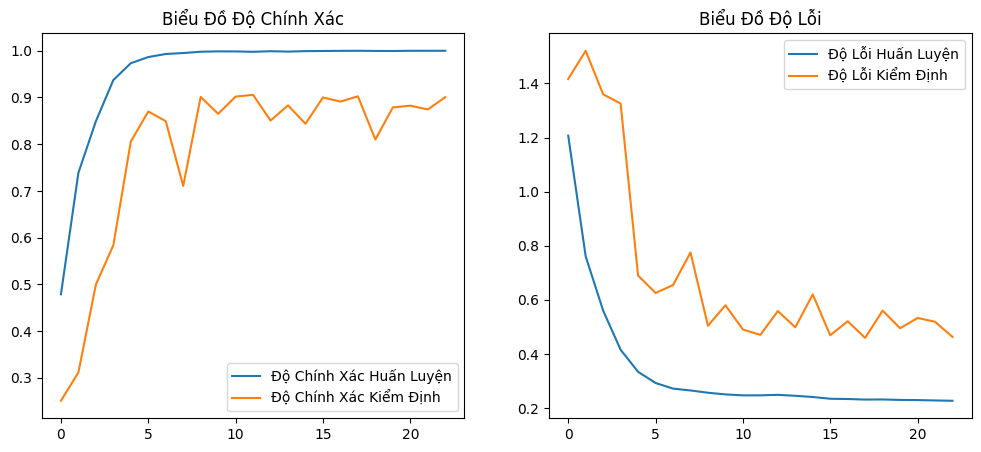


Đánh giá mô hình trên tập kiểm định:
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9268 - loss: 0.3980
Độ chính xác trên tập kiểm định: 90.25%
Giá trị mất mát (loss): 0.4590
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


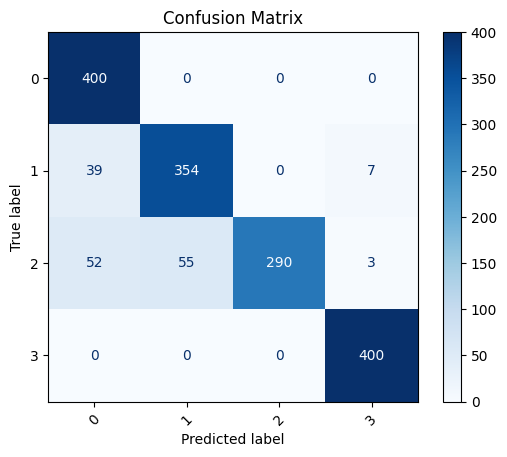


Báo cáo Precision, Recall, F1-score:
              precision    recall  f1-score   support

           0       0.81      1.00      0.90       400
           1       0.87      0.89      0.88       400
           2       1.00      0.72      0.84       400
           3       0.98      1.00      0.99       400

    accuracy                           0.90      1600
   macro avg       0.91      0.90      0.90      1600
weighted avg       0.91      0.90      0.90      1600



In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Độ Chính Xác Huấn Luyện')
plt.plot(epochs_range, val_acc, label='Độ Chính Xác Kiểm Định')
plt.legend(loc='lower right')
plt.title('Biểu Đồ Độ Chính Xác')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Độ Lỗi Huấn Luyện')
plt.plot(epochs_range, val_loss, label='Độ Lỗi Kiểm Định')
plt.legend(loc='upper right')
plt.title('Biểu Đồ Độ Lỗi')
plt.show()


print("\nĐánh giá mô hình trên tập kiểm định:")
val_eval_loss, val_eval_acc = model.evaluate(validation_generator, verbose=1)
print(f"Độ chính xác trên tập kiểm định: {val_eval_acc*100:.2f}%")
print(f"Giá trị mất mát (loss): {val_eval_loss:.4f}")

validation_generator.reset()
Y_pred = model.predict(validation_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(validation_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

print("\nBáo cáo Precision, Recall, F1-score:")
report = classification_report(
    validation_generator.classes,
    y_pred,
    target_names=CLASS_NAMES
)
print(report)


In [9]:
model_filename = 'hand_gesture_cnn_model_4_gestures_final.h5'
model_save_path = os.path.join('/content/drive/MyDrive', model_filename)
model.save(model_save_path)
print(f"\nMo hinh da duoc luu vao Google Drive tai: '{model_save_path}'")


Mo hinh da duoc luu vao Google Drive tai: '/content/drive/MyDrive/hand_gesture_cnn_model_4_gestures_final.h5'
